<h1>T3T4 layer visualization</h1>

This notebook is provided to show the way to see the built model from autoBioSeqpy. A part of the functions in this notebook is provided in the script "tool/layerPlot.py" as well.

NOTE: The script used 3rd module <a href=https://github.com/lmcinnes/umap>UMAP</a> for layer plotting.

<h2>1. Preparation</h2>

In this notebook, few packages are necessary. 

Assuming that we are in <b>'root-of-autoBioSeqpy/notebook/T3T4'</b>, then we need to add the search path and import the modules.

Please install <b>UMAP, matplotlib, tensorFlow and keras</b> before using this notebook.

In [1]:
import os, sys
sys.path.append('../../tool/libs')
sys.path.append('../..')
sys.path.append('..')
oriPath = os.path.curdir
import paraParser
import moduleRead
import dataProcess
#import analysisPlot
import numpy as np
#from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
import tensorflow as tf
from utils import TextDecorate, evalStrList
from keras.models import Model
from keras.models import Sequential

import umap
import umap.plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Using TensorFlow backend.


Using <a href=https://github.com/lmcinnes/umap>UMAP</a> is a simple way for model visualization, but still we need the model as well as the data for generating the predicted data for plotting. Thus, here we need few steps to get a built model and the related data.

<h3>1.1 Model building</h3>

As the first step, we need a model from running.py, users could build a model by using the command line below in the root of autoBioSeqpy:

<b>python running.py --dataType protein --dataEncodingType dict --dataTrainFilePaths examples/T3T4/dataset/trainT3.txt examples/T3T4/dataset/trainT4.txt --dataTrainLabel 1 0 --dataTestFilePaths examples/T3T4/dataset/testT3.txt examples/T3T4/dataset/testT4.txt --dataTestLabel 1 0 --modelLoadFile examples/T3T4/model/RNN.py --verbose 1 --outSaveFolderPath tmpOut --savePrediction 1 --saveFig 1 --batch_size 25 --epochs 40 --shuffleDataTrain 1 --showFig 1 --modelSaveName tmpMod.json --weightSaveName tmpWeight.bin --noGPU 0 --paraSaveName parameters.txt --spcLen 1500
</b>

The outputs will be saved at <b>your-work-path/tmpOut</b>, including the parameters, the path of the data and constructure of the model.

Alternativly, ususally a built model is already provided in <b>your-work-path/notebook/T3T4/models/RNN</b>, thus users could skip this step by using the provided one.

If users would like to use their own model, please don't forget to save the model and the weight by using parameters "--modelSaveName" and "--weightSaveName".

<h3>1.2 Parameter pasering and data loading</h3>
Here we use the parameters which saved in <b>your-work-path/notebook/T3T4/models/RNN</b> directly. We can get the information easily by using the <b>paraParser</b> module.

In [2]:
paraFile = './models/RNN/parameters.txt'
paraDict = paraParser.parseParametersFromFile(paraFile)
#print
for k in paraDict:
    print('%r: %r' %(k,paraDict[k]))

'dataType': ['protein']
'dataEncodingType': ['dict']
'spcLen': [1500]
'firstKernelSize': []
'dataTrainFilePaths': ['examples/T3T4/dataset/trainT3.txt', 'examples/T3T4/dataset/trainT4.txt']
'dataTrainLabel': [1, 0]
'dataTestFilePaths': ['examples/T3T4/dataset/testT3.txt', 'examples/T3T4/dataset/testT4.txt']
'dataTestLabel': [1, 0]
'dataTrainModelInd': []
'dataTestModelInd': []
'outSaveFolderPath': 'tmpOut'
'showFig': True
'saveFig': True
'figDPI': 300
'savePrediction': True
'dataSplitScale': None
'modelLoadFile': ['examples/T3T4/model/RNN.py']
'weightLoadFile': []
'shuffleDataTrain': True
'shuffleDataTest': False
'batch_size': 25
'epochs': 40
'useKMer': []
'KMerNum': []
'inputLength': []
'loss': 'binary_crossentropy'
'optimizer': 'optimizers.Adam()'
'metrics': ['acc', 'acc']
'modelSaveName': 'tmpMod.json'
'weightSaveName': 'tmpWeight.bin'
'noGPU': False
'paraFile': None
'paraSaveName': 'parameters.txt'
'seed': 1
'labelToMat': False
'colorText': 'Auto'
'verbose': True
'reshapeSize': []


Few preparing...

In [3]:
paraDict['dataTestFilePaths'] = paraDict['dataTrainFilePaths']
paraDict['dataTestModelInd'] = paraDict['dataTrainModelInd']
paraDict['dataTestLabel'] = paraDict['dataTrainLabel']
paraDict['outSaveFolderPath'] = './notebook/LayerUMAP of T3T4 case for points extracting/models/RNN/'
os.chdir('../../')#to the root path of autoBioSeqpy


#parameters
dataTypeList = paraDict['dataType']
dataEncodingType = paraDict['dataEncodingType']
spcLen = paraDict['spcLen']
firstKernelSize = paraDict['firstKernelSize']

dataTestFilePaths = paraDict['dataTestFilePaths']
dataTestLabel = paraDict['dataTestLabel']

dataSplitScale = paraDict['dataSplitScale']
outSaveFolderPath = paraDict['outSaveFolderPath']
showFig = paraDict['showFig']
saveFig = paraDict['saveFig']
savePrediction = paraDict['savePrediction']

loss = paraDict['loss']
optimizer = paraDict['optimizer']
if not optimizer.startswith('optimizers.'):
    optimizer = 'optimizers.' + optimizer
if not optimizer.endswith('()'):
    optimizer = optimizer + '()'
metrics = paraDict['metrics']

shuffleDataTrain = paraDict['shuffleDataTrain']
shuffleDataTest = paraDict['shuffleDataTest']
batch_size = paraDict['batch_size']
epochs = paraDict['epochs']

inputLength = paraDict['inputLength']
modelSaveName = paraDict['modelSaveName']
weightSaveName = paraDict['weightSaveName']
noGPU = paraDict['noGPU']
labelToMat = paraDict['labelToMat']


modelLoadFile = paraDict['modelLoadFile']
useKMerList = paraDict['useKMer']
if len(useKMerList ) == 0:
    useKMerList = [False] * len(modelLoadFile)
KMerNumList = paraDict['KMerNum']
if len(KMerNumList ) == 0:
    KMerNumList = [3] * len(modelLoadFile)
    
dataTestModelInd = paraDict['dataTestModelInd']
if len(modelLoadFile) == 1:
    dataTestModelInd = [0] * len(dataTestFilePaths)

modelPredictFile = outSaveFolderPath + os.path.sep + modelSaveName
weightLoadFile = outSaveFolderPath + os.path.sep + weightSaveName


model = moduleRead.readModelFromJsonFileDirectly(modelPredictFile,weightLoadFile)

Then we begin to generate the dataset by encoding the sequences.

The code below is from predicting.py, to see how the code works, please see the other notebook '<b>tutorial in jupyter notebook.ipynb</b>' instead.

In [4]:
td = TextDecorate()
    
verbose = paraDict['verbose']

predictionSavePath = None
for i,k in enumerate(sys.argv):
    if k == '--predictionSavePath':
        predictionSavePath = sys.argv[i+1]
    elif k == '--verbose':
        verbose = sys.argv[i+1]

colorText = paraDict['colorText']
if colorText.lower() == 'auto':
    import platform
    if 'win' in platform.system().lower():
        td.disable()
elif not bool(eval(colorText)):
    td.disable()
    
if noGPU:
    if verbose:
        td.printC('As set by user, gpu will be disabled.','g')
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
else:
    #check the version of tensorflow before configuration
    tfVersion = tf.__version__
    if int(tfVersion.split('.')[0]) >= 2:
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True

        sess =tf.compat.v1.Session(config=config)
    else:
        config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
        sess = tf.Session(config=config)


if not len(dataTypeList) == len(modelLoadFile):
    if verbose:
        td.printC('Please provide enough data type(s) as the number of --modelLoadFile','r')
assert len(dataTypeList) == len(modelLoadFile)

featureGenerators = []
for i,subDataType in enumerate(dataTypeList):
    if subDataType.lower() == 'protein':
        if verbose:
            td.printC('Enconding protein data for model %d ...' %i,'b')
        featureGenerator = dataProcess.ProteinFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'dna':
        if verbose:
            td.printC('Enconding DNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.DNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'rna':
        if verbose:
            td.printC('Enconding RNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.RNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'other':
        if verbose:
            td.printC('Reading CSV-like data for model %d ...' %i,'b')
        featureGenerator = dataProcess.OtherFeatureGenerator()
    else:
        td.printC('Unknow dataType %r, please use \'protein\', \'dna\' ,\'rna\' or \'other\'' %subDataType, 'r')
    featureGenerators.append(featureGenerator)
    assert subDataType.lower() in ['protein','dna','rna','other']

if verbose:
    td.printC('Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...','b')
assert len(dataTestFilePaths) > 0

if verbose:
    td.printC('Begin to generate test dataset...','b')

testDataLoadDict = {}    
for modelIndex in range(len(modelLoadFile)):
    testDataLoadDict[modelIndex] = []
#    testDataLoaders = []
for i,dataPath in enumerate(dataTestFilePaths):
    modelIndex = dataTestModelInd[i]
    featureGenerator = featureGenerators[modelIndex]
    dataLoader = dataProcess.DataLoader(label = dataTestLabel[i], featureGenerator=featureGenerator)
    dataLoader.readFile(dataPath, spcLen = spcLen[modelIndex])
    testDataLoadDict[modelIndex].append(dataLoader)

testDataMats = []
testLabelArrs = []
testNameLists = []
for modelIndex in range(len(modelLoadFile)):
    testDataLoaders = testDataLoadDict[modelIndex]
    testDataSetCreator = dataProcess.DataSetCreator(testDataLoaders)
    testDataMat, testLabelArr, nameList = testDataSetCreator.getDataSet(toShuffle=False, withNameList=True)
    testDataMats.append(testDataMat)
    testLabelArrs.append(testLabelArr)
    testNameLists.append(nameList)
if verbose:
    td.printC('Test datasets generated.','g')
nameTemp = testNameLists[0]    
testDataMats, testLabelArrs, sortedIndexes = dataProcess.matAlignByName(testDataMats,nameTemp,testLabelArrs,testNameLists)
testNameLists = [nameTemp] * len(testNameLists)
    
tmpTempLabel = testLabelArrs[0]
for tmpLabel in testLabelArrs:
    assert np.sum(np.array(tmpTempLabel) - np.array(tmpLabel)) == 0   

if labelToMat:
    if verbose:
        td.printC('Since labelToMat is set, the labels would be changed to onehot-like matrix','g')
    testLabelArr,testLabelArrDict,testArrLabelDict = dataProcess.labelToMat(testLabelArrs[0])
#    print(testLabelArr)
else:
    testLabelArr = testLabelArrs[0]


Enconding protein data for model 0 ...
Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...
Begin to generate test dataset...
Test datasets generated.


In [5]:
print('%d matrix generated:\n' %(len(testDataMats)))
for i in range(len(testDataMats)):
    print('Matrix and label %d:' %i)
    print(testDataMats[i])
    print(testLabelArrs[i])
    print('\n')

1 matrix generated:

Matrix and label 0:
[[12 18 17 ... 20 20 20]
 [12  5  7 ... 20 20 20]
 [12 10  3 ... 20 20 20]
 ...
 [12 13 11 ... 20 20 20]
 [12  3  5 ... 20 20 20]
 [12  1  1 ... 20 20 20]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

<h3>1.3 model loading</h3>

Using the <b>moduleRead</b> module could load the model easily, then the components are ready.

In [6]:
if verbose:
    td.printC('Checking module file for modeling','b')
if modelPredictFile is None:
    if verbose:
        td.printC('please provide a model file in a json file.','r')
if weightLoadFile is None:
    if verbose:
        td.printC('the weight file is necessary for predicting, otherwise the model will be with initialized weight','r')
assert not modelPredictFile is None
assert not weightLoadFile is None

if verbose:
    td.printC('Loading module and weight file','b')
model = moduleRead.readModelFromJsonFileDirectly(modelPredictFile,weightLoadFile)
if verbose:
    td.printC('Module loaded, generating the summary of the module','b')
    model.summary()

Checking module file for modeling
Loading module and weight file
Module loaded, generating the summary of the module
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 256)         6656      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 171,137
Trainable params: 171,137
Non-trainable params: 0
_________________________________________________________________


The model will be different as user set. Some times there will be a "sequential" layer, which is a wrapped model, in the summary, this time, we can umpack the "sequential" layer into 'un-wrapped' layers.

We provided few functions in 'layPlot.py', but here we can do it manually.

First of all, let us see what is in the sequential. A function is used to make this process more simple.

In [7]:
def unBoundLayers(modelIn,layers = []):
    for layer in modelIn.layers:
        if not 'sequential' in layer.name.lower():
            layers.append(layer)
        else:
            unBoundLayers(layer,layers)
    return layers

In [8]:
layers = unBoundLayers(model)
for i, layer in enumerate(layers):
    print('layer %d: %s' %(i,layer.name))

layer 0: embedding_1
layer 1: bidirectional_1
layer 2: dropout_1
layer 3: dense_1


Then, we need to generate a new model which change the output layer to a hidden layer. If the model contain multiple input layer, usually only the layer after concatenate is available.

In [9]:
newModel = Model(inputs=model.input,outputs=model.layers[-2].output)

Now the model above is available for UMAP.

NOTE: Usually we have to spesify the input shape of the input layer, but autoBioSeqpy will check when training, thus here we don't have to do this step.

<h2>2. Using UMAP for layer visualization</h2>

UMAP need the predicted values from the model and the labels from the data, then the figure could be generated. Here the <b>testDataMats</b> is already changed to the training data.

Since the output layer is changed, the shape will be the same as the output of the such layer.

In [10]:
predicted_Probability = newModel.predict(testDataMats[0])

In [11]:
predicted_Probability.shape

(474, 128)

Using UMAP could get the representation that if the data are divided correctly, but still we might want to know the points which in the incorrect cluster, thus here we can export the axis to get the details.

In [12]:
labels = np.array(['T3SE'] * len(testDataLoaders[0].names) + ['T4SE'] * len(testDataLoaders[1].names), dtype=str)

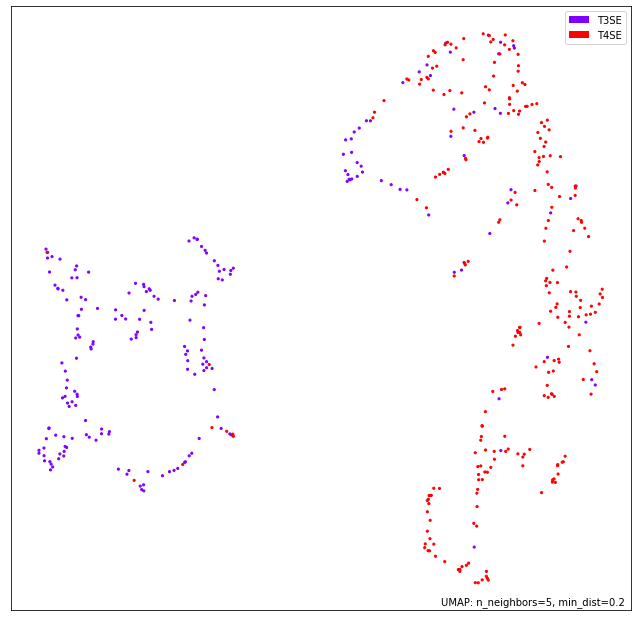

In [13]:
# the featureDict could contain more parameters, use '?umap.UMAP' for more details.
featureDict={
        'n_neighbors' : 5,
        'min_dist' : 0.2,   
        'n_components' : 2,
        'metric' : 'euclidean',
        }

mapper = umap.UMAP(**featureDict).fit(predicted_Probability)
plotObj = umap.plot.points(mapper, labels=labels, color_key_cmap='rainbow')
plt.show()

One way is to use the <b>umap.plot.show</b> to see the polts interactively, a map of the label can make the visualization better.

In [14]:
import pandas as pd

In [15]:
hover_data = pd.DataFrame({'index':testDataLoaders[0].names+testDataLoaders[1].names,
                           'label':testLabelArr})

In [16]:
p = umap.plot.interactive(mapper, labels=testLabelArr, hover_data=hover_data, point_size=2)
umap.plot.show(p)

Another way is to set some rule to find out the outliers manually. Using <b>embedding_</b> in a UMAP <b>mapper</b> can get the axis.

In [17]:
mapper.embedding_

array([[ 0.9316582 ,  3.8164847 ],
       [-2.3377733 ,  8.230084  ],
       [-2.3078566 ,  6.790329  ],
       [-0.44041458,  3.0224233 ],
       [ 1.29006   ,  7.5469356 ],
       [-2.608568  ,  5.0782375 ],
       [ 1.0169852 ,  5.803272  ],
       [ 5.3817277 , 10.825273  ],
       [ 5.491621  , 10.714897  ],
       [ 7.683624  ,  9.8088875 ],
       [ 8.971061  , 12.393945  ],
       [-1.4152312 ,  4.35912   ],
       [-0.23452942,  7.1096044 ],
       [ 0.2972708 ,  3.3529317 ],
       [ 1.2898746 ,  6.677911  ],
       [11.06515   ,  6.2290864 ],
       [ 8.411719  ,  8.367937  ],
       [ 8.618542  ,  8.42285   ],
       [-2.092538  ,  7.679395  ],
       [-2.6282172 ,  7.674417  ],
       [ 7.4121013 , 13.408151  ],
       [ 1.6683521 ,  4.7297473 ],
       [ 1.3128618 ,  8.921087  ],
       [ 0.42692146,  3.3859675 ],
       [ 8.297599  , 13.904215  ],
       [-1.4312134 ,  4.2985945 ],
       [ 1.105766  ,  7.8671875 ],
       [ 0.8107089 ,  6.3895993 ],
       [ 8.570468  ,

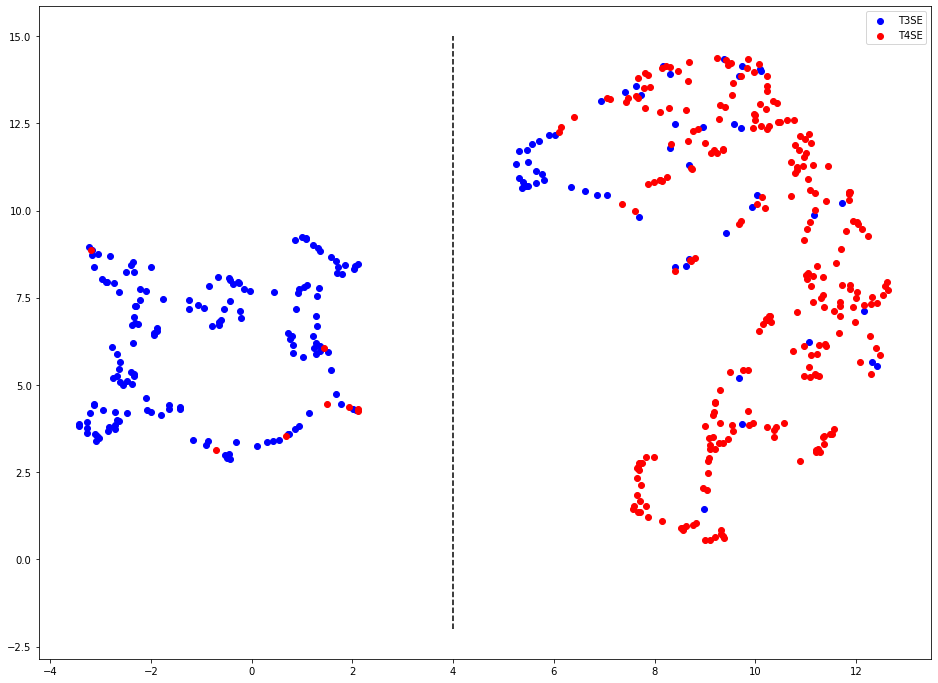

In [20]:
plt.figure(figsize=(16,12))
t3Num = testLabelArr.sum() #1:T3,0:T4
t3s = plt.scatter(mapper.embedding_[:t3Num, 0], mapper.embedding_[:t3Num, 1], color='b')
t4s = plt.scatter(mapper.embedding_[t3Num:, 0], mapper.embedding_[t3Num:, 1], color='r')
tmpLine = plt.plot([4]*18,np.arange(-2,16),'--',color='black')
plt.legend((t3s, t4s),
           ('T3SE', 'T4SE'),
           #           loc='lower left',
           )
plt.show()

With the polt above, we can find that this time the two cluster could be roughly divided by <b>x=4</b>

In [21]:
nameList = np.array(testDataLoaders[0].names+testDataLoaders[1].names)

In [24]:
errList = []
tmpIndex = (mapper.embedding_[:,0] < 4).astype(int) * (np.array(testLabelArr) == 0).astype(int)
errList += list(nameList[np.arange(len(tmpIndex))[tmpIndex.astype(np.bool)]])
tmpIndex = (mapper.embedding_[:,0] > 4).astype(int) * (np.array(testLabelArr) == 1).astype(int)
errList += list(nameList[np.arange(len(tmpIndex))[tmpIndex.astype(np.bool)]])

In [25]:
print(errList)

['trainT4.txt_Q5ZWF6', 'trainT4.txt_WP_011181145.1', 'trainT4.txt_WP_010974921.1', 'trainT4.txt_Q5ZV52', 'trainT4.txt_Q5ZVF7', 'trainT4.txt_WP_010974922.1', 'trainT4.txt_NP_059824.1', 'trainT4.txt_WP_011997383.1', 'trainT3.txt_Q89TX4', 'trainT3.txt_B5R8S6', 'trainT3.txt_O84718', 'trainT3.txt_Q9Z780', 'trainT3.txt_Q8ZNP4', 'trainT3.txt_Q663L9', 'trainT3.txt_D2TRA0', 'trainT3.txt_P33548', 'trainT3.txt_EKJ11176.1', 'trainT3.txt_Q63K40', 'trainT3.txt_O84723', 'trainT3.txt_B7UMC8', 'trainT3.txt_Q7NUX3', 'trainT3.txt_O84625', 'trainT3.txt_C5IZN1', 'trainT3.txt_A9MG90', 'trainT3.txt_Q9Z7E2', 'trainT3.txt_O84085', 'trainT3.txt_Q9Z8P7', 'trainT3.txt_Q9AN16', 'trainT3.txt_P0A1K5', 'trainT3.txt_Q89N83', 'trainT3.txt_Q881L7', 'trainT3.txt_Q57P56', 'trainT3.txt_P40699', 'trainT3.txt_O84855', 'trainT3.txt_P40296', 'trainT3.txt_D2TI15', 'trainT3.txt_B9A810', 'trainT3.txt_Q9Z8X8', 'trainT3.txt_P0CZ04', 'trainT3.txt_D2AJU3', 'trainT3.txt_Q9REZ7', 'trainT3.txt_O84056', 'trainT3.txt_Q4ZXP9', 'trainT3.txt

That's all the informations for plotting the layer by using their outputs and UMAP. If you still have more issues, please fell free to connect us at ljs@swmu.edu.cn, thanks.